## Supervised learning assignemtn
##### Name: Daan Steur
##### Studentnumber: 379943
##### Supervisor: Drs. Bart Barnard
##### Course: DSLS Data Science 3: Supervised learning
##### Date: 27th of may

### Prediction of health parameters based on patient informatio. 

#### Assignment 
Load, inspect and clean the data. Split the data into a training set and a validation set and a test set. Use a simple classifier as a baseline. Train various classifiers. Motivate your choice in relation to the characteristics of the dataset. Try to combine them into an ensemble learning model that outperforms all of the others

#### Background


#### Data source
Blood Pressure Data for disease Prediction
(kaggle) : https://www.kaggle.com/datasets/pavanbodanki/blood-press?resource=download


#### Refrences

Data Collection

In [6]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from tabulate import tabulate
from sklearn import linear_model
from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix

In [7]:
# load data
data = pd.read_csv("data.csv")
# Data.drop(['Adrenal_and_thyroid_disorders','Chronic_kidney_disease'], axis=1, inplace=True)
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Patient_Number                 2000 non-null   int64  
 1   Blood_Pressure_Abnormality     2000 non-null   int64  
 2   Level_of_Hemoglobin            2000 non-null   float64
 3   Genetic_Pedigree_Coefficient   1908 non-null   float64
 4   Age                            2000 non-null   int64  
 5   BMI                            2000 non-null   int64  
 6   Sex                            2000 non-null   int64  
 7   Pregnancy                      442 non-null    float64
 8   Smoking                        2000 non-null   int64  
 9   Physical_activity              2000 non-null   int64  
 10  salt_content_in_the_diet       2000 non-null   int64  
 11  alcohol_consumption_per_day    1758 non-null   float64
 12  Level_of_Stress                2000 non-null   i

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0


Data Exploration (EDA)

In [8]:
def data_exploration_csv(filepath):
    # Set console printing options 
    pd.set_option('display.max_rows', 500)
    pd.set_option('display.max_columns', 20)
    pd.set_option('display.width', 1000)

    # Upload the data
    df = pd.read_csv(filepath, sep = ",", decimal =".",  keep_default_na = False, na_values = '', index_col=0)
    # Column indices of selected continuous variables
    cols_continuous = [1,2,3,4,5,6,7,8,9,10,11]
    # Data frame of the continuous variables
    df_num = df.iloc[:,cols_continuous]
    # Column indices of selected discrete variables
    cols_discrete = [0,12]
    # Data frame of the discrete variables
    df_cat = df.iloc[:,cols_discrete]
    # Continuous variables, descriptive statistics
    df_num.sort_index(axis=1, inplace=True, key=lambda x: x.str.lower())
    df_num_stats = df_num.describe()
    df_num_stats = df_num_stats.transpose()
    df_num_stats.drop(columns=['25%', '75%'], inplace=True)
    df_num_stats.rename(columns={"count": "N Valid", "mean": "Mean", "50%": "Median", 
                                "std": "SD", "min": "Min", "max": "Max"}, inplace=True)
    df_num_stats["N Obs"] = df_num.shape[0]
    df_num_stats["N Missing"] = df_num.isna().sum()
    df_num_stats["% Complete"] = (df_num_stats["N Valid"] / df_num_stats["N Obs"])*100
    df_num_stats["N Unique"] = df_num.nunique(dropna=True)
    df_num_stats["MAD"] = df_num.apply(lambda x: stats.median_abs_deviation(x, scale="normal", nan_policy='omit'))    
    df_num_stats["Skewness"] = df_num.skew(axis=0)
    df_num_stats["Kurtosis"] = df_num.kurtosis(axis=0)
    df_num_stats.loc[df_num_stats["Min"]>0,"CV"] = df_num_stats["SD"] / df_num_stats["Mean"]
    df_num_stats = df_num_stats.round(2)
    df_num_stats.loc[df_num_stats["Min"]<=0,"CV"] = ""

    ## Reorder columns to be similar to the output of the R app 
    df_num_stats = df_num_stats.reindex(columns=["N Obs", "N Missing", "N Valid", 
                                                "% Complete", "N Unique", "Mean", 
                                                "SD", "Median", "MAD", "Min", "Max", 
                                                "Skewness", "Kurtosis", "CV"]) 

    ## Restrict size of characters of index 
    cnames = np.array(df_num_stats.index).astype('str')
    csize = min(np.max(np.char.str_len(cnames)),25)
    df_num_stats.index = list(map(lambda x: x[0:csize], cnames))

    ## Output
    print(tabulate(df_num_stats, headers='keys', tablefmt="simple"))
    
def Categorical_Variables_csv(filepath):
    #Pre_processing
    # Set console printing options 
    pd.set_option('display.max_rows', 5000)
    pd.set_option('display.max_columns', 200)
    pd.set_option('display.width', 10000)

    # Upload the data
    df = pd.read_csv(filepath, sep = ",", decimal =".",  keep_default_na = False, na_values = '', index_col=0)
    
    # Column indices of selected continuous variables
    cols_continuous = [1,2,3,4,5,6,7,8,9,10,11]
    # Data frame of the continuous variables
    df_num = df.iloc[:,cols_continuous]
    # Column indices of selected discrete variables
    cols_discrete = [0,12]
    # Data frame of the discrete variables
    df_cat = df.iloc[:,cols_discrete]
    
    ## Table Totals 
    nobs = np.ones(df_cat.shape[1])*df_cat.shape[0]
    nobs = nobs.astype(int)
    df_cat.sort_index(axis=1, inplace=True, key=lambda x: x.str.lower())
    df_cat = df_cat.astype("string")
    df_cat_stats = pd.DataFrame(nobs, columns=['N Obs'], index=df_cat.columns)
    df_cat_stats["N Missing"] = df_cat.isna().sum()
    df_cat_stats["N Valid"] = df_cat.count()
    df_cat_stats["% Complete"] = (df_cat_stats["N Valid"] / df_cat_stats["N Obs"])*100
    df_cat_stats["N Unique"] = df_cat.nunique(dropna=False)
    df_cat_stats = df_cat_stats.round(2)

    ### Restrict size of characters of index 
    cnames = np.array(df_cat_stats.index).astype('str')
    csize = min(np.max(np.char.str_len(cnames)),25)
    df_cat_stats.index = list(map(lambda x: x[0:csize], cnames))

    ### Output
    print(tabulate(df_cat_stats, headers='keys', tablefmt="simple"))


data_exploration_csv("data.csv")
Categorical_Variables_csv("data.csv")

                             N Obs    N Missing    N Valid    % Complete    N Unique      Mean        SD    Median       MAD    Min       Max    Skewness    Kurtosis  CV
-------------------------  -------  -----------  ---------  ------------  ----------  --------  --------  --------  --------  -----  --------  ----------  ----------  ----
Age                           2000            0       2000         100            58     46.56     17.11     46        22.24   18       75           0.02       -1.25  0.37
alcohol_consumption_per_d     2000          242       1758          87.9         488    251.01    143.65    250       186.81    0      499          -0.01       -1.22
BMI                           2000            0       2000         100            41     30.08     11.76     30        14.83   10       50          -0.02       -1.18  0.39
Genetic_Pedigree_Coeffici     2000           92       1908          95.4         101      0.49      0.29      0.49      0.37    0        1          

C:\Users\31613\AppData\Local\Temp\ipykernel_118928\2899805427.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num.sort_index(axis=1, inplace=True, key=lambda x: x.str.lower())


c:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:1106: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


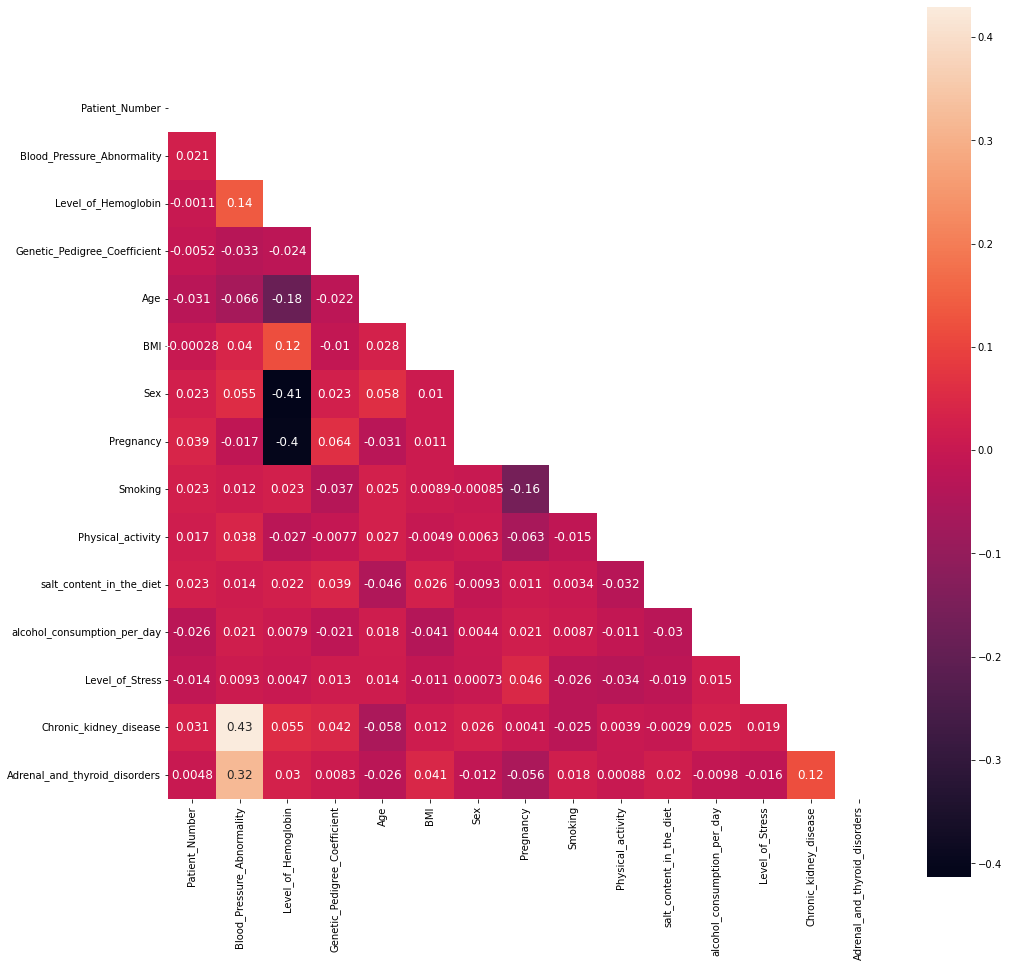

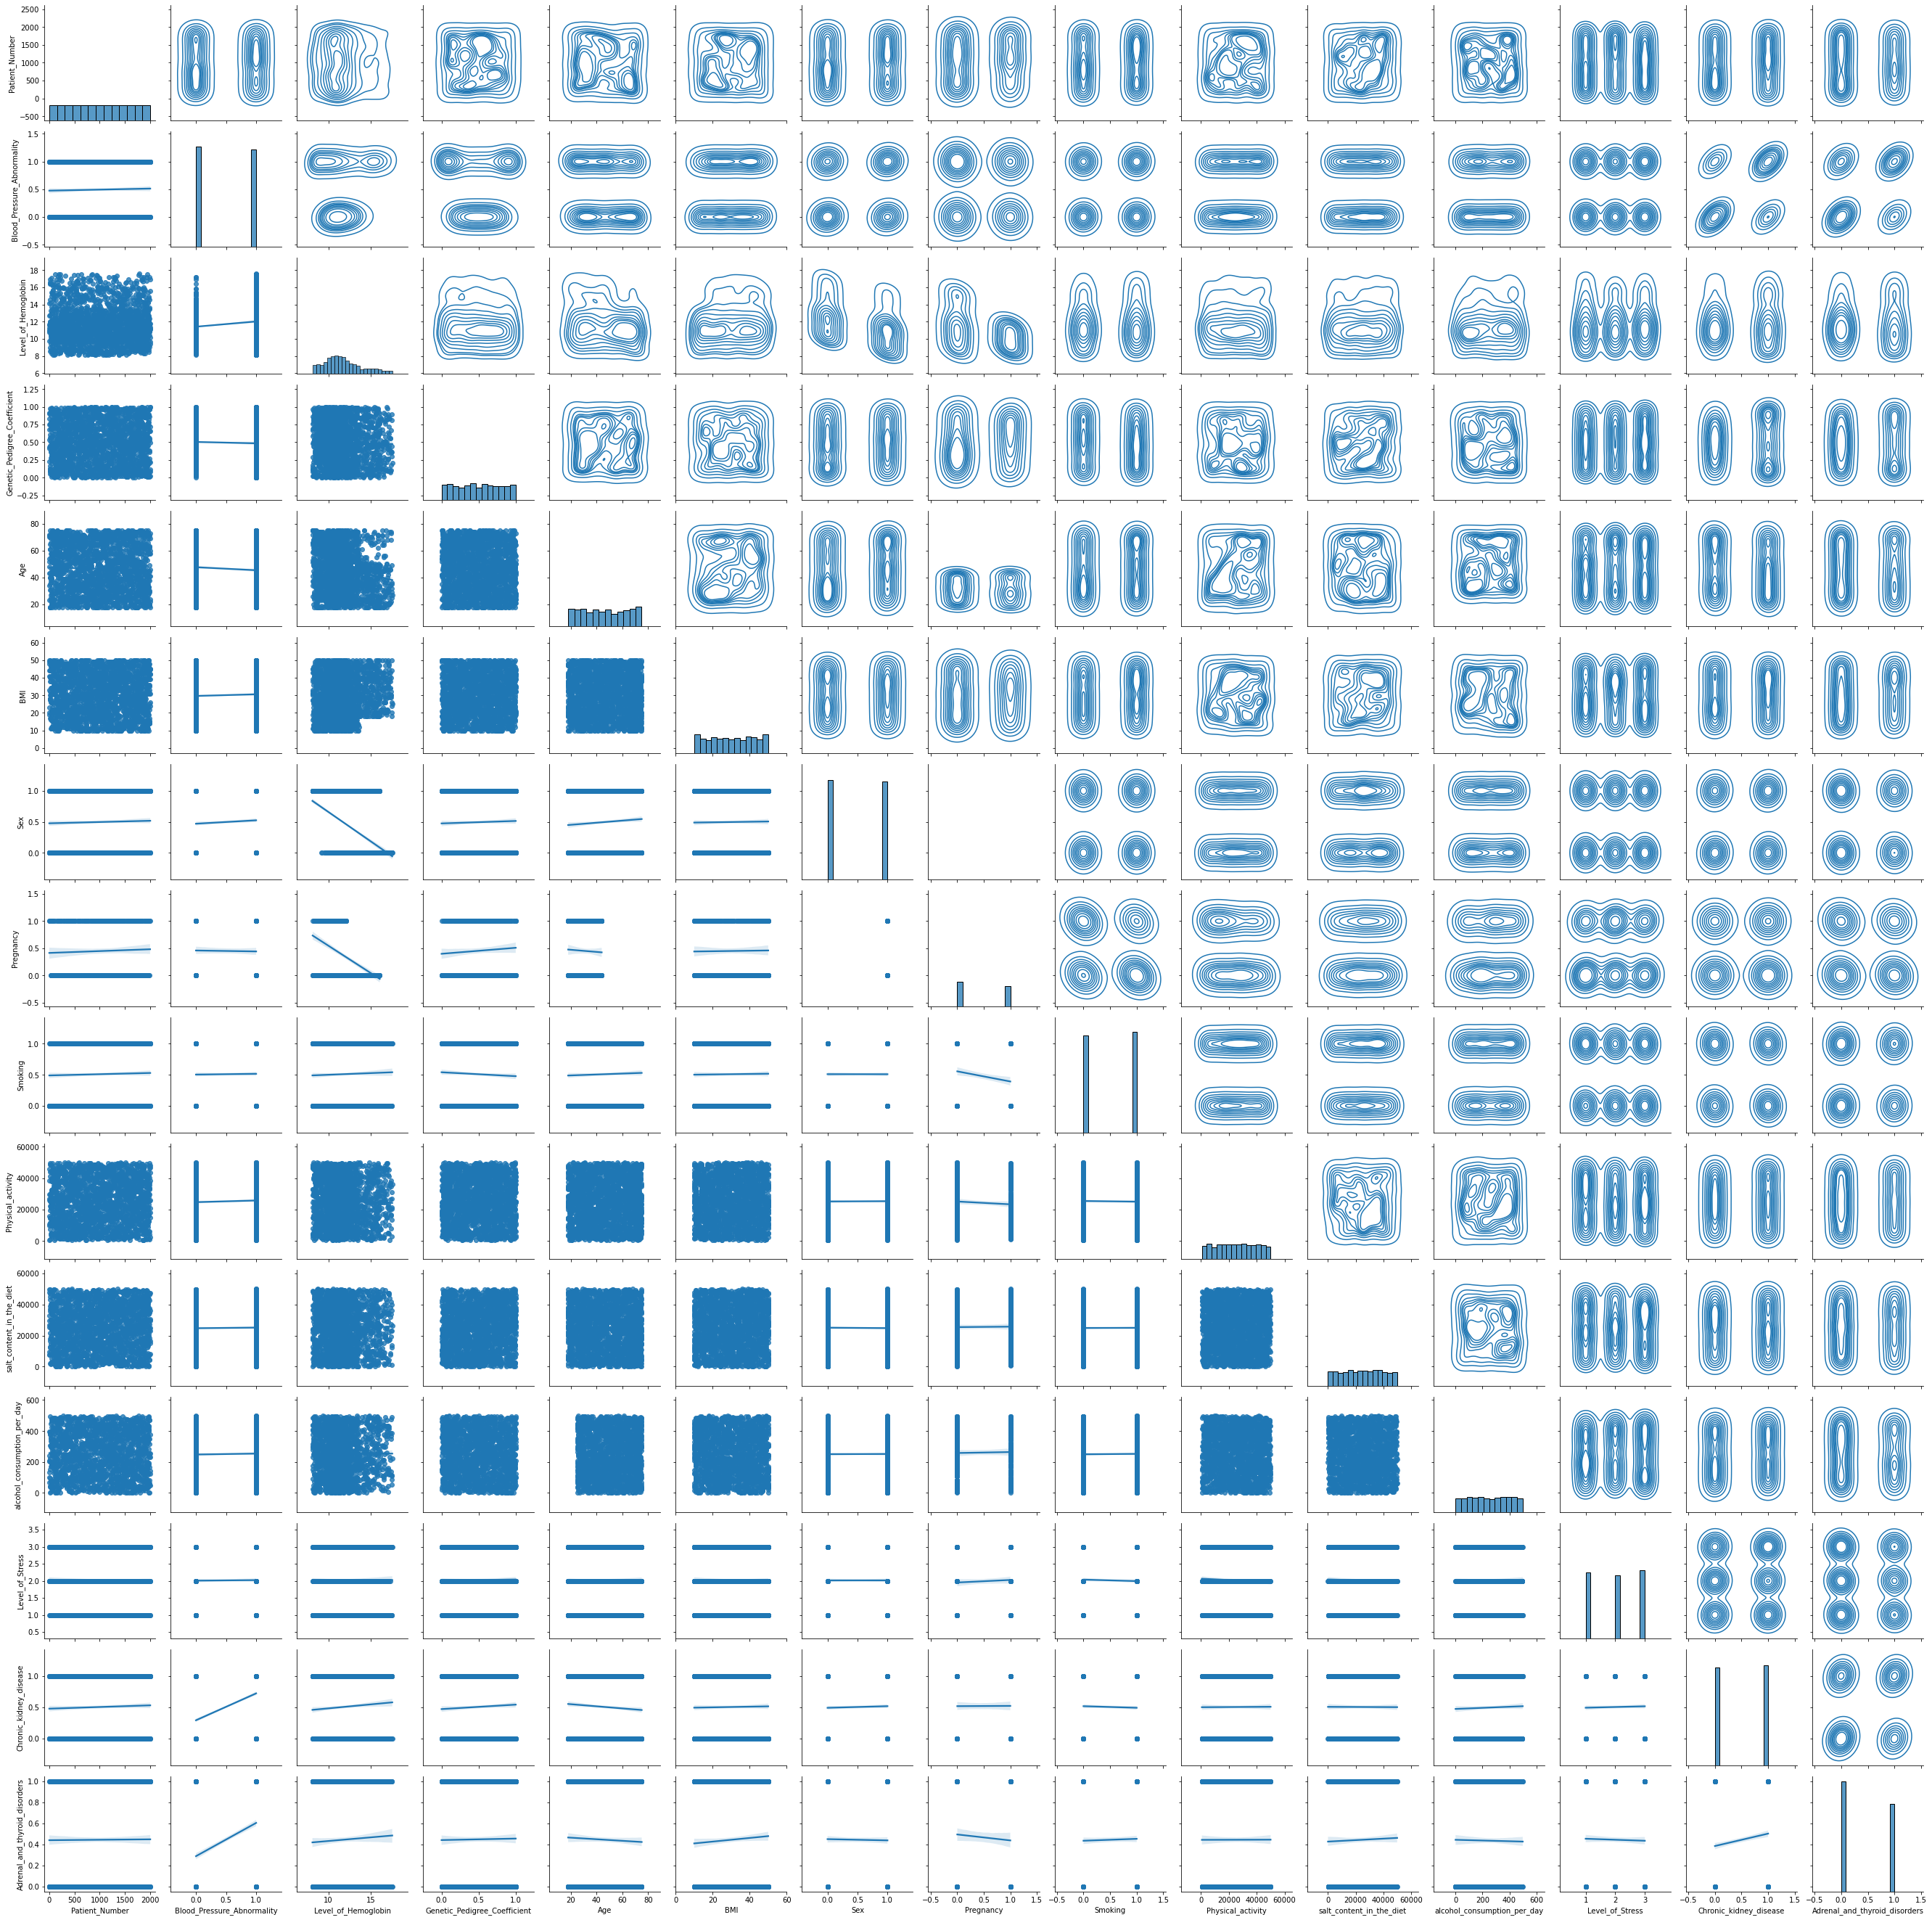

In [24]:
# Calculate correlation between each pair of variable
corr_matrix=data.corr()
 
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
plt.figure(figsize=(16,16))
sns.heatmap(corr_matrix, annot=True, annot_kws={"size": 12}, square=True, mask=mask)

g = sns.PairGrid(data)
g.map_lower(sns.regplot)
g.map_diag(sns.histplot)
g.map_upper(sns.kdeplot)


Data Preparation

,Patient_Number,Blood_Pressure_Abnormality,Level_of_Hemoglobin,Genetic_Pedigree_Coefficient,Age,BMI,Sex,Pregnancy,Smoking,Physical_activity,salt_content_in_the_diet,alcohol_consumption_per_day,Level_of_Stress,Chronic_kidney_disease,Adrenal_and_thyroid_disorders
0,1,1,11.28,0.90,34,23,1,1.0,0,45961,48071,NaN,2,1,1
1,2,0,9.75,0.23,54,33,1,NaN,0,26106,25333,205.0,3,0,0
2,3,1,10.79,0.91,70,49,0,NaN,0,9995,29465,67.0,2,1,0
3,4,0,11.00,0.43,71,50,0,NaN,0,10635,7439,242.0,1,1,0
4,5,1,14.17,0.83,52,19,0,NaN,0,15619,49644,397.0,2,0,0


Model Choosing

Training Model

SyntaxError: invalid syntax (2925981508.py, line 2)

Evaluting Model

Parameter Tuning

Predictions

Summary